In [189]:
import pandas as pd
from pathlib import Path
import numpy as np

In [190]:
# 1 라이브러리 임포트

import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn as sk

# 알고리즘을 그래픽화 하기위한 라이브러리
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import rcParams
import re
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
import keras

# 모델생성 라이브러리
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# 데이터 스플릿,스케일링
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [191]:
DATAPATH = Path('./playground-series-s3e1/')
# N_ESTIMATORS = 100_000

train = pd.read_csv(DATAPATH/'train.csv')
test = pd.read_csv(DATAPATH/'test.csv')
sample_sub = pd.read_csv(DATAPATH/'sample_submission.csv')

In [192]:
# 쉐잎 조회
# y 값은 MedHouseVal 임 근데 숫자니까 회귀 모델임
print(train.shape)
train.head()

(37137, 10)


,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,0,2.3859,15.0,3.827160,1.112100,1280.0,2.486989,34.60,-120.12,0.980
1,1,3.7188,17.0,6.013373,1.054217,1504.0,3.813084,38.69,-121.22,0.946
2,2,4.7750,27.0,6.535604,1.103175,1061.0,2.464602,34.71,-120.45,1.576
3,3,2.4138,16.0,3.350203,0.965432,1255.0,2.089286,32.66,-117.09,1.336
4,4,3.7500,52.0,4.284404,1.069246,1793.0,1.604790,37.80,-122.41,4.500


In [193]:
# 칼럼별 na 값 조회 이 데이터는 nan 이 없음 
train.isna().sum()

id             0
MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

In [194]:
# 데이터 전처리1. 데이터 스플릿


x = train.drop(["MedHouseVal","id"],axis=1)
y = train["MedHouseVal"]
# print(x.shape,test.shape)
print(x.shape,y.shape)

(37137, 8) (37137,)


In [195]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train,y_test = train_test_split(
    x,
    y,
    train_size=0.8,
    shuffle = True,
    # stratify = y,
    # random_state=1
)
print(x_train.shape,x_test.shape)
print(y_train.shape,y_test.shape)

(29709, 8) (7428, 8)
(29709,) (7428,)


In [196]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29709 entries, 90 to 21294
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      29709 non-null  float64
 1   HouseAge    29709 non-null  float64
 2   AveRooms    29709 non-null  float64
 3   AveBedrms   29709 non-null  float64
 4   Population  29709 non-null  float64
 5   AveOccup    29709 non-null  float64
 6   Latitude    29709 non-null  float64
 7   Longitude   29709 non-null  float64
dtypes: float64(8)
memory usage: 2.0 MB


In [197]:
# 데이터 스케일링 

scaler = MinMaxScaler()

scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [198]:
print(x_train.shape,y_train.shape)

(29709, 8) (29709,)


In [199]:
# 5 모델구성

dr = 0.1
model = Sequential([
    Dense(256,input_dim=8,activation="relu"),
    Dropout(rate=dr),
    Dense(128,activation="relu"),
    Dropout(rate=dr),
    Dense(64,activation="relu"),
    Dropout(rate=dr),
    Dense(32,activation="relu"),
    Dropout(rate=dr),
    Dense(16,activation="relu"),
    Dropout(rate=dr),
    Dense(8,activation="relu"),
    Dropout(rate=dr),
    Dense(4,activation="relu"),
    Dropout(rate=dr),
    Dense(2,activation="relu"),
    Dropout(rate=dr),
# 이진분할 이기때문에 출력층 1 , sigmoid
    Dense(1)
])
model.summary()


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_117 (Dense)           (None, 256)               2304      
                                                                 
 dropout_88 (Dropout)        (None, 256)               0         
                                                                 
 dense_118 (Dense)           (None, 128)               32896     
                                                                 
 dropout_89 (Dropout)        (None, 128)               0         
                                                                 
 dense_119 (Dense)           (None, 64)                8256      
                                                                 
 dropout_90 (Dropout)        (None, 64)                0         
                                                                 
 dense_120 (Dense)           (None, 32)              

In [200]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

early_stopping = EarlyStopping(
monitor='val_loss',
mode='min',
patience=30, 
min_delta=0.0001,
verbose=1, 
)

plat =ReduceLROnPlateau(
        monitor="val_loss", 
        mode='min', 
        patience=3, 
        factor=0.1, 
        min_lr=1e-8, 
        min_delta=0.000001)

model.compile(loss="mse",optimizer="adam")

hist = model.fit(x_train, y_train, epochs=500, 
                 validation_split=0.2,
                 batch_size=128, 
                 verbose=1,
                 callbacks = [early_stopping,plat])


Epoch 1/500
186/186 [==============================] - 2s 5ms/step - loss: 1.9933 - val_loss: 1.0031 - lr: 0.0010
Epoch 2/500
186/186 [==============================] - 1s 4ms/step - loss: 1.2291 - val_loss: 0.8780 - lr: 0.0010
Epoch 3/500
186/186 [==============================] - 1s 4ms/step - loss: 1.0594 - val_loss: 0.8387 - lr: 0.0010
Epoch 4/500
186/186 [==============================] - 1s 4ms/step - loss: 0.9505 - val_loss: 0.6992 - lr: 0.0010
Epoch 5/500
186/186 [==============================] - 1s 4ms/step - loss: 0.8967 - val_loss: 0.7500 - lr: 0.0010
Epoch 6/500
186/186 [==============================] - 1s 4ms/step - loss: 0.8575 - val_loss: 0.7155 - lr: 0.0010
Epoch 7/500
186/186 [==============================] - 1s 4ms/step - loss: 0.7822 - val_loss: 0.6006 - lr: 0.0010
Epoch 8/500
186/186 [==============================] - 1s 4ms/step - loss: 0.7440 - val_loss: 0.6128 - lr: 0.0010
Epoch 9/500
186/186 [==============================] - 1s 4ms/step - loss: 0.7275 - val_

In [201]:
scores = model.evaluate(x_train, y_train, batch_size=30)
# print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


991/991 [==============================] - 1s 1ms/step - loss: 0.4707


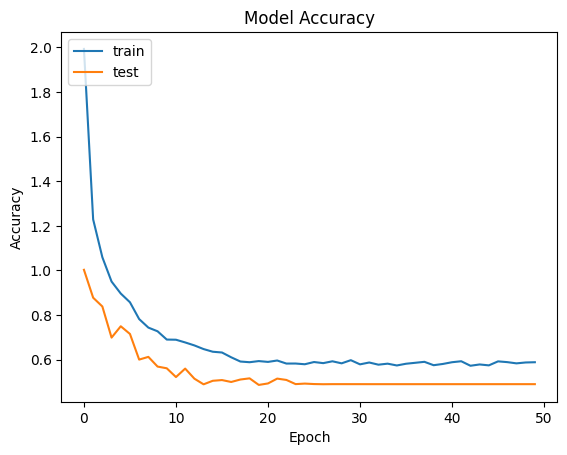

In [202]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [203]:
test = test.drop(["id"],axis=1)
y_submit = model.predict(test)
print(y_submit[:20])

# # 1 과 1로 이진변환해주는 코드
# y_submit =y_submit.flatten()
# # y_predict 가 0.5 보다 크면 1 아니면 0 반환
# y_submit = np.where(y_submit > 0.5, 1 , 0)
# print(y_submit[:20])

774/774 [==============================] - 1s 1ms/step
[[130.03172 ]
 [ 86.29876 ]
 [114.98128 ]
 [168.47832 ]
 [ 30.90483 ]
 [165.62135 ]
 [139.95372 ]
 [142.67163 ]
 [161.67038 ]
 [ 34.847107]
 [132.01538 ]
 [108.28157 ]
 [ 63.831917]
 [ 61.184917]
 [155.36089 ]
 [171.90616 ]
 [ 79.87932 ]
 [115.4143  ]
 [155.48756 ]
 [130.65588 ]]


In [205]:
preds =[]

preds.append(model.predict(test))
pred = np.average(np.array(preds),axis=0)

pred

# 15-3 경로와 파일명 지정
submission = pd.read_csv(DATAPATH/'sample_submission.csv',index_col="id")
# submission = pd.read_csv(DATAPATH/"sample_submission.csv",index_col="id")
submission['MedHouseVal'] = pred
submission.to_csv(DATAPATH/"submission_3.csv")


774/774 [==============================] - 1s 1ms/step
